In [1]:
# Data manipulation
import pandas as pd  
import numpy as np  

# Data visualization
import seaborn as sns  
import matplotlib.pyplot as plt  

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder  
from sklearn.compose import ColumnTransformer  
from sklearn.pipeline import Pipeline  

# Dimensionality reduction
from sklearn.decomposition import PCA  

# Clustering
from sklearn.cluster import KMeans  
from sklearn.metrics import silhouette_score  

# Geospatial calculations
from haversine import haversine, Unit  

# Question 1: EDA

Let's check reviews

In [2]:
reviews = pd.read_csv('reviews.csv')
print(reviews.dtypes)

listing_id     int64
date          object
dtype: object


In [3]:
reviews

,listing_id,date
0,3109,2017-10-28
1,3109,2017-11-03
2,3109,2018-07-24
3,3109,2019-10-24
4,7397,2011-04-08
...,...,...
2063005,1300202998608690521,2024-12-05
2063006,1300572603716148635,2024-12-04
2063007,1300746099933712518,2024-12-02
2063008,1301237374868511796,2024-12-04


In [4]:
# Convert 'last_review' to datetime 
reviews['date'] = pd.to_datetime(reviews['date'])
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063010 entries, 0 to 2063009
Data columns (total 2 columns):
 #   Column      Dtype         
---  ------      -----         
 0   listing_id  int64         
 1   date        datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 31.5 MB


In [5]:
reviews.isnull().sum().sort_values(ascending=False)

listing_id    0
date          0
dtype: int64

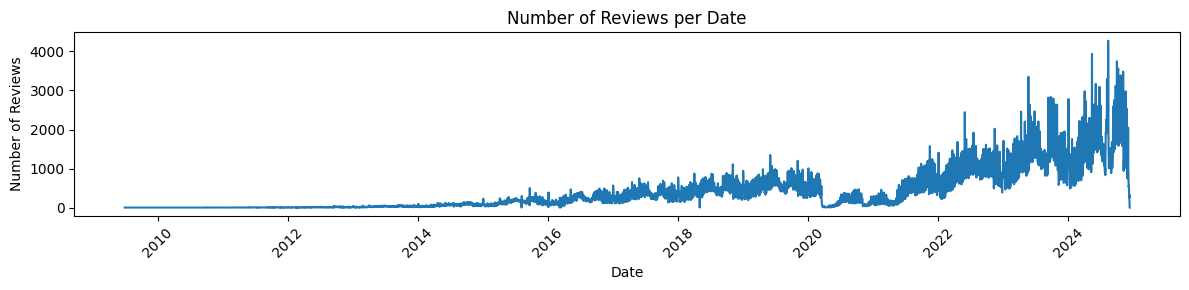

In [6]:
#Graph of reviews per date
#Aux variables
reviews_per_date = reviews.groupby('date')['listing_id'].count().reset_index()
reviews_per_date.rename(columns={'listing_id': 'review_count'}, inplace=True)
#Plotting
plt.figure(figsize=(12, 3))
sns.lineplot(x='date', y='review_count', data=reviews_per_date)
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

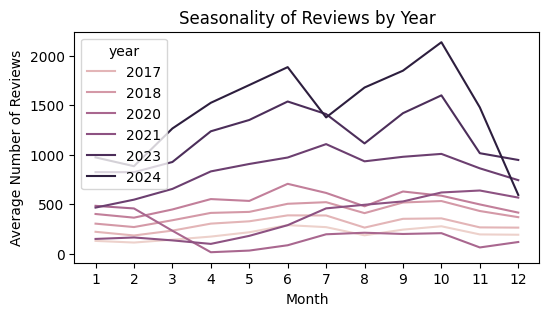

In [7]:
# Filter data to include only from 2016 onwards
reviews_2016_onwards = reviews[reviews['date'].dt.year >= 2016]

#Count reviews per day and create 'review_count' column
review_counts = reviews_2016_onwards.groupby('date')['listing_id'].count().reset_index()
review_counts.rename(columns={'listing_id': 'review_count'}, inplace=True)
review_counts['year'] = review_counts['date'].dt.year
review_counts['month'] = review_counts['date'].dt.month

# Group by year and month to calculate average review count
seasonality = review_counts.groupby(['year', 'month'])['review_count'].mean().reset_index()

# Plotting
plt.figure(figsize=(6, 3))
sns.lineplot(x='month', y='review_count', hue='year', data=seasonality)
plt.xlabel('Month')
plt.ylabel('Average Number of Reviews')
plt.title('Seasonality of Reviews by Year')
plt.xticks(range(1, 13))
plt.show()

<img src="image-20250302-105050.png" width="" align="" />

The number of Airbnb reviews in Paris reached a low point during the months the Olympics were hosted (August 2024)

Comment aside, I wouldn't exclude dates in the listings dataframe, because we are looking for patterns and reasons for the prices to be higher  for the month in which the olympics took place, so we actually need the old information. 

Now let's check Listings

In [8]:
listings = pd.read_csv('listings.csv')

In [9]:
listings

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,5396,Your perfect Paris studio on Île Saint-Louis,7903,Borzou,NaN,Hôtel-de-Ville,48.852470,2.358350,Entire home/apt,88.0,3,425,2024-11-23,2.26,1,77,51,7510402838018
1,7964,Sunny apartment with balcony,22155,Anaïs,NaN,Opéra,48.874170,2.342450,Entire home/apt,NaN,7,5,2015-09-14,0.03,1,0,0,7510903576564
2,9952,Paris petit coin douillet,33534,Elisabeth,NaN,Popincourt,48.862380,2.369570,Entire home/apt,150.0,4,52,2024-09-24,0.36,1,250,3,7511101582862
3,11487,"Heart of Paris, brand new aparment.",42666,Brigitte,NaN,Popincourt,48.863510,2.371100,Entire home/apt,80.0,30,13,2024-09-27,0.09,2,246,5,"Available with a mobility lease only (""bail mo..."
4,12452,Voltaire Charm,48733,Irene,NaN,Popincourt,48.859740,2.379320,Entire home/apt,201.0,1,62,2024-10-11,0.77,1,34,4,7511102600669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91026,1304562779094087796,Studio ensoleillé sur Canal,38574929,Anna,NaN,Buttes-Chaumont,48.888360,2.382689,Entire home/apt,100.0,30,0,NaN,NaN,1,85,0,"Available with a mobility lease only (""bail mo..."
91027,1304667478167694444,Studio bohémien,595527331,Ahmed,NaN,Ménilmontant,48.864770,2.391108,Entire home/apt,80.0,1,0,NaN,NaN,1,180,0,7512014848156
91028,1305050902233494632,Cozy Apartment - Marais - Pelee,156775524,Merveil,NaN,Popincourt,48.859996,2.369208,Entire home/apt,818.0,1,0,NaN,NaN,107,264,0,7511114844445
91029,1305061192394005038,Cozy Apartment - Tour Eiffel - Finlay,156775524,Merveil,NaN,Vaugirard,48.852970,2.288317,Entire home/apt,840.0,1,0,NaN,NaN,107,316,0,7511514844533


Listings Types, there doesn't seem to be problems according to columns names and Type of variable. Although we can already detect missing values.

In [10]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91031 entries, 0 to 91030
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              91031 non-null  int64  
 1   name                            91031 non-null  object 
 2   host_id                         91031 non-null  int64  
 3   host_name                       91022 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   91031 non-null  object 
 6   latitude                        91031 non-null  float64
 7   longitude                       91031 non-null  float64
 8   room_type                       91031 non-null  object 
 9   price                           60093 non-null  float64
 10  minimum_nights                  91031 non-null  int64  
 11  number_of_reviews               91031 non-null  int64  
 12  last_review                     

Checking categorical values 

In [11]:
listings["neighbourhood"].value_counts()

neighbourhood
Buttes-Montmartre      9963
Popincourt             8071
Vaugirard              7222
Batignolles-Monceau    6300
Entrepôt               6253
Passy                  5750
Buttes-Chaumont        5109
Ménilmontant           4933
Opéra                  4447
Temple                 3936
Reuilly                3589
Observatoire           3335
Bourse                 3148
Gobelins               2995
Panthéon               2923
Élysée                 2911
Hôtel-de-Ville         2727
Palais-Bourbon         2686
Luxembourg             2664
Louvre                 2069
Name: count, dtype: int64

In [12]:
listings["room_type"].value_counts()

room_type
Entire home/apt    81068
Private room        8850
Hotel room           732
Shared room          381
Name: count, dtype: int64

In [13]:
listings["last_review"].value_counts()

last_review
2024-12-01    1682
2024-11-24    1372
2024-11-17    1055
2024-11-03     856
2024-12-02     836
              ... 
2021-03-28       1
2014-10-12       1
2014-10-27       1
2014-08-29       1
2015-04-21       1
Name: count, Length: 3310, dtype: int64

Last_review should be a date

In [14]:
# Convert 'last_review' to datetime 
listings['last_review'] = pd.to_datetime(listings['last_review'])
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91031 entries, 0 to 91030
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              91031 non-null  int64         
 1   name                            91031 non-null  object        
 2   host_id                         91031 non-null  int64         
 3   host_name                       91022 non-null  object        
 4   neighbourhood_group             0 non-null      float64       
 5   neighbourhood                   91031 non-null  object        
 6   latitude                        91031 non-null  float64       
 7   longitude                       91031 non-null  float64       
 8   room_type                       91031 non-null  object        
 9   price                           60093 non-null  float64       
 10  minimum_nights                  91031 non-null  int64         
 11  nu

This variable has numerical license values and also can be equal to text, doesn't seem to be on the scope of our analysis.

In [15]:
listings["license"].value_counts()

license
Available with a mobility lease only ("bail mobilité")    7171
Exempt - hotel-type listing                               1340
7512345678900                                              145
7511007051216                                               27
7510301376711                                               25
                                                          ... 
7514973509900                                                1
7512004878437                                                1
7510206267320                                                1
7511806411982                                                1
7512006233665                                                1
Name: count, Length: 60921, dtype: int64

Let's check numerical variables: neighbourhood_category is totally NaN or 0, so we shouldn't use it. ID and host_id are useful for identifying listings, but won't probably be included in analysis of price. There seems to be outliers in price, minimum nights, number of reviews, reviews per month, calculated host listing counts and number of reviews ltm. 

In [16]:
listings.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,9.103100e+04,9.103100e+04,0.0,91031.000000,91031.000000,60093.000000,91031.000000,91031.000000,67176,67176.000000,91031.000000,91031.000000,91031.000000
mean,6.081553e+17,1.818846e+08,NaN,48.864181,2.343099,252.590485,41.515945,22.662719,2023-08-07 10:27:57.170417920,1.065495,23.583010,133.604014,5.910613
min,3.109000e+03,2.626000e+03,NaN,48.816090,2.227420,7.000000,1.000000,0.000000,2010-05-28 00:00:00,0.010000,1.000000,0.000000,0.000000
25%,3.233102e+07,1.956359e+07,NaN,48.850740,2.321011,100.000000,2.000000,0.000000,2023-09-18 00:00:00,0.210000,1.000000,0.000000,0.000000
50%,8.113895e+17,7.262684e+07,NaN,48.865470,2.346829,150.000000,3.000000,5.000000,2024-08-25 00:00:00,0.590000,1.000000,88.000000,1.000000
75%,1.092549e+18,3.394154e+08,NaN,48.879055,2.368320,250.000000,5.000000,22.000000,2024-11-09 00:00:00,1.420000,2.000000,267.000000,7.000000
max,1.305100e+18,6.654112e+08,NaN,48.901510,2.467120,30400.000000,1000.000000,3436.000000,2024-12-10 00:00:00,49.380000,826.000000,365.000000,780.000000
std,5.127971e+17,2.006094e+08,NaN,0.018198,0.034228,594.242875,107.573306,55.594056,NaN,1.353293,94.650167,135.627545,11.745001


In [17]:
listings.duplicated().sum()

0

Missing Values

In [18]:
listings.isnull().sum().sort_values(ascending=False)

neighbourhood_group               91031
price                             30938
last_review                       23855
reviews_per_month                 23855
license                           18786
host_name                             9
name                                  0
id                                    0
neighbourhood                         0
host_id                               0
room_type                             0
longitude                             0
latitude                              0
number_of_reviews                     0
minimum_nights                        0
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
dtype: int64

In [19]:
# Missing Values ("N/A"s)
missing_values = listings.isnull().sum().sort_values(ascending=False)/len(listings)*100
missing_values

neighbourhood_group               100.000000
price                              33.986224
last_review                        26.205359
reviews_per_month                  26.205359
license                            20.636926
host_name                           0.009887
name                                0.000000
id                                  0.000000
neighbourhood                       0.000000
host_id                             0.000000
room_type                           0.000000
longitude                           0.000000
latitude                            0.000000
number_of_reviews                   0.000000
minimum_nights                      0.000000
calculated_host_listings_count      0.000000
availability_365                    0.000000
number_of_reviews_ltm               0.000000
dtype: float64

Text(0.5, 1.0, 'Missing Values Heatmap (%)')

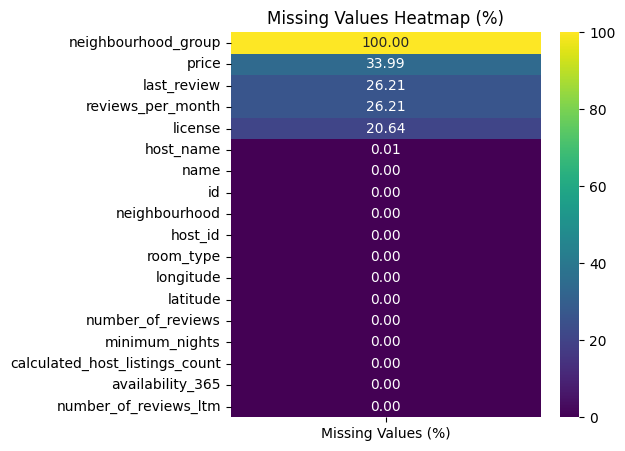

In [20]:
plt.figure(figsize=(5, 5))
sns.heatmap(pd.DataFrame(missing_values, columns=['Missing Values (%)']), annot=True, cmap='viridis', fmt=".2f") 
plt.title('Missing Values Heatmap (%)')

We have a high amount of missing values in last_review, reviews_per_month, license and price. These last variables are crucial for our research reason why we are not excluding them from this EDA, but neighbourhood_group is going to be dropped given the fact that is 100% empty.

In [21]:
listings = listings.drop('neighbourhood_group', axis=1)  

Outliers in numerical variables

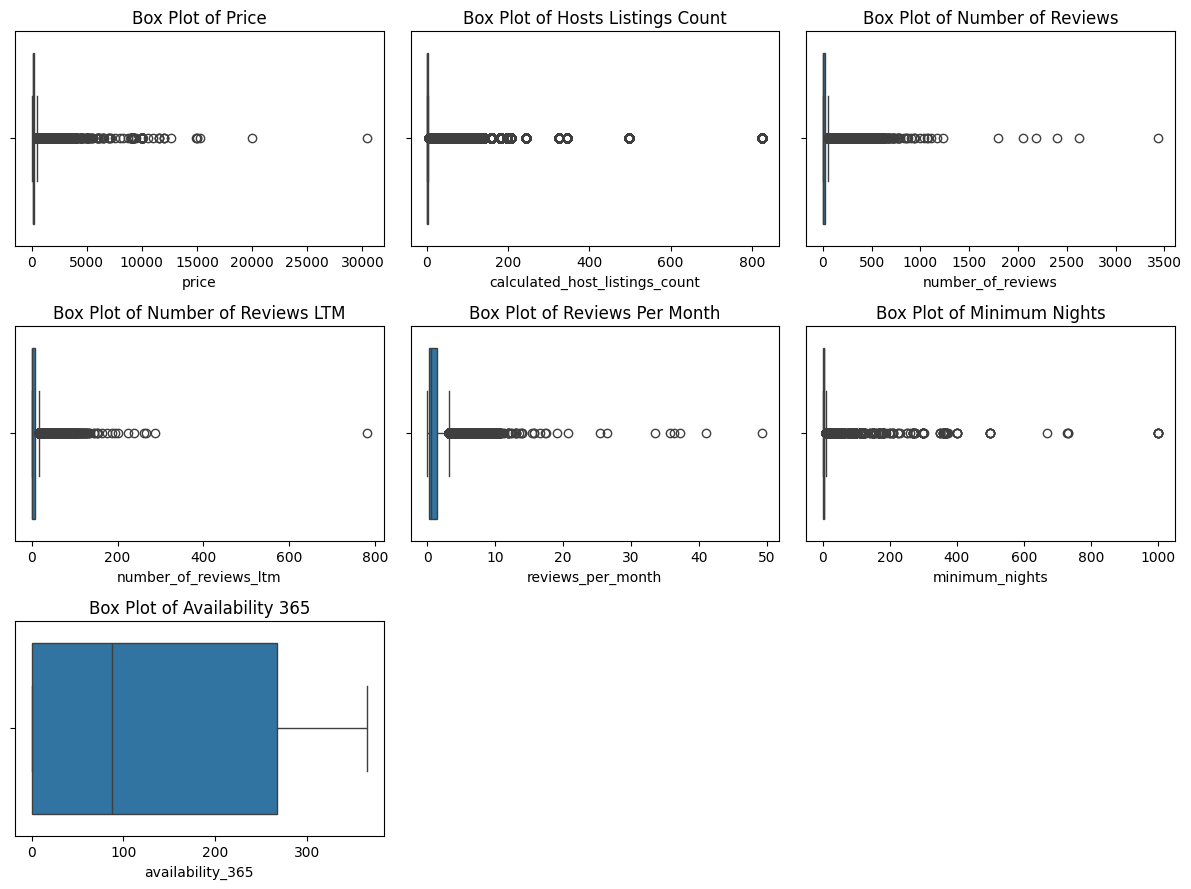

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

columns = [
    'price', 'calculated_host_listings_count', 'number_of_reviews', 
    'number_of_reviews_ltm', 'reviews_per_month', 'minimum_nights', 'availability_365'
]
titles = [
    'Box Plot of Price', 'Box Plot of Hosts Listings Count', 'Box Plot of Number of Reviews', 
    'Box Plot of Number of Reviews LTM', 'Box Plot of Reviews Per Month', 'Box Plot of Minimum Nights', 
    'Box Plot of Availability 365'
]

axes = axes.flatten()

for i, col in enumerate(columns):
    sns.boxplot(x=listings[col], ax=axes[i])
    axes[i].set_title(titles[i])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Pre-processing exploration

Given the nature of the variables, it seems to be necessary to scale some of the numeric variables and also use one hot encoder to transform categorical variables to numeric. We used both standard and robust scaler, and one hot encoder, but the results in terms of correlation between price and other variables aren't relevant. Because of this, the preprocessing is going to be done with the data set as it is, and we will do this transformation at the end, for further steps.

In [23]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Define categorical and numerical columns
categorical_features = ['room_type', 'neighbourhood']
numerical_features = ['price', 'minimum_nights', 'number_of_reviews', 
                     'calculated_host_listings_count', 'availability_365', 
                     'number_of_reviews_ltm', 'reviews_per_month']

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),  # Use MinMaxScaler for numerical features
        ('cat', OneHotEncoder(), categorical_features)  # One-hot encode categorical features
    ],
    remainder='passthrough'  # Include any other columns as is (if any)
)

# Fit and transform the data
processed_data = preprocessor.fit_transform(listings)

# Convert to DataFrame for easier interpretation, maintaining original and new column names
# Get feature names for the transformed features
new_column_names = preprocessor.get_feature_names_out()

# Create  DataFrame 
processed_df = pd.DataFrame(processed_data, columns=new_column_names)

print(processed_df)

      num__price num__minimum_nights num__number_of_reviews  \
0       0.002665            0.002002                0.12369   
1            NaN            0.006006               0.001455   
2       0.004705            0.003003               0.015134   
3       0.002402            0.029029               0.003783   
4       0.006383                 0.0               0.018044   
...          ...                 ...                    ...   
91026    0.00306            0.029029                    0.0   
91027   0.002402                 0.0                    0.0   
91028   0.026684                 0.0                    0.0   
91029   0.027408                 0.0                    0.0   
91030   0.001941            0.001001                    0.0   

      num__calculated_host_listings_count num__availability_365  \
0                                     0.0              0.210959   
1                                     0.0                   0.0   
2                                     0.0 

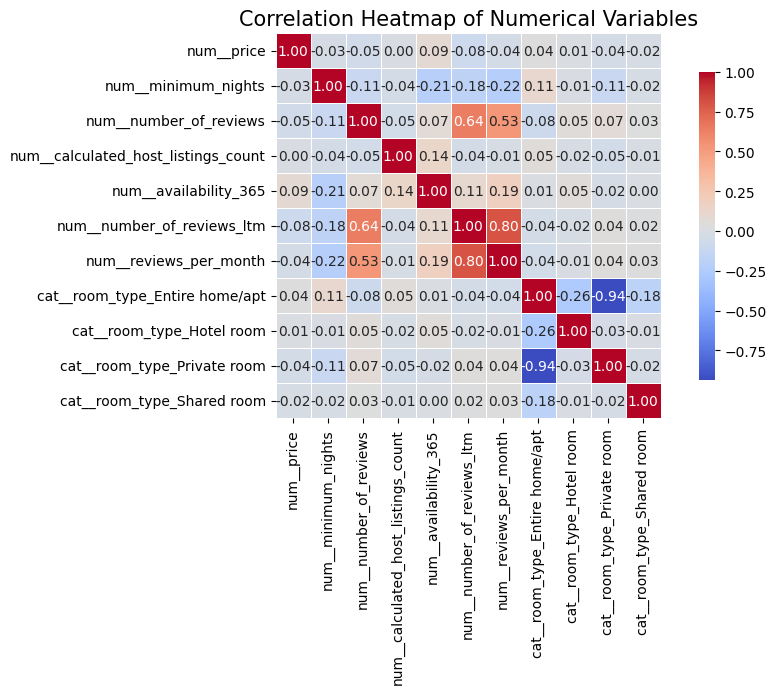

In [24]:
# Identify the numerical columns to plot
numerical_columns = [
    'num__price', 
    'num__minimum_nights', 
    'num__number_of_reviews', 
    'num__calculated_host_listings_count', 
    'num__availability_365', 
    'num__number_of_reviews_ltm',
    'num__reviews_per_month',
    'cat__room_type_Entire home/apt', 
    'cat__room_type_Hotel room', 
    'cat__room_type_Private room', 
    'cat__room_type_Shared room'
]

# Convert these columns to numeric types
for col in numerical_columns:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')

# columns for correlation analysis
scaled_numerical_df = processed_df.select_dtypes(include=['float64', 'int64'])

# Check if there are any numerical columns available
if not scaled_numerical_df.empty:
    # Calculate the correlation matrix
    correlation_matrix = scaled_numerical_df.corr()

    # Set plot
    plt.figure(figsize=(10, 5))

    # heatmap
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                linewidths=0.5, square=True, cbar_kws={"shrink": .8})

    #  title
    plt.title('Correlation Heatmap of Numerical Variables', fontsize=15)

    # plot
    plt.show()
else:
    print("No numerical columns found for correlation analysis.")

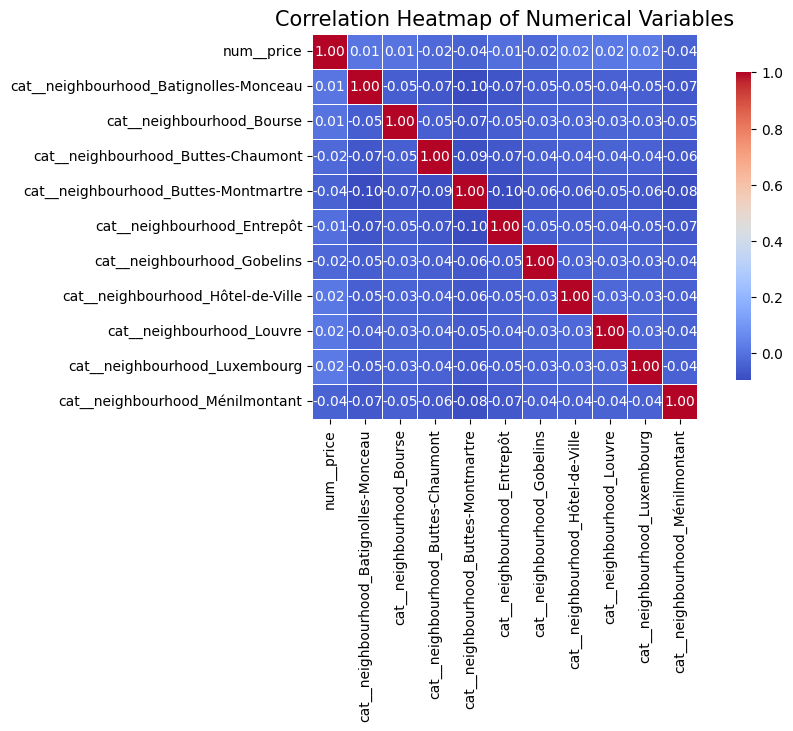

In [25]:
numerical_columns_two = [
    'num__price', 
    'cat__neighbourhood_Batignolles-Monceau', 
    'cat__neighbourhood_Bourse', 
    'cat__neighbourhood_Buttes-Chaumont', 
    'cat__neighbourhood_Buttes-Montmartre', 
    'cat__neighbourhood_Entrepôt', 
    'cat__neighbourhood_Gobelins', 
    'cat__neighbourhood_Hôtel-de-Ville', 
    'cat__neighbourhood_Louvre', 
    'cat__neighbourhood_Luxembourg', 
    'cat__neighbourhood_Ménilmontant'

]
# Convert these columns to numeric types
for col in numerical_columns_two:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')

scaled_numerical_two_df = processed_df[numerical_columns_two]

# Calculate the correlation matrix
correlation_matrix = scaled_numerical_two_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
    linewidths=0.5, square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Heatmap of Numerical Variables', fontsize=15)

    # Show the plot
plt.show()

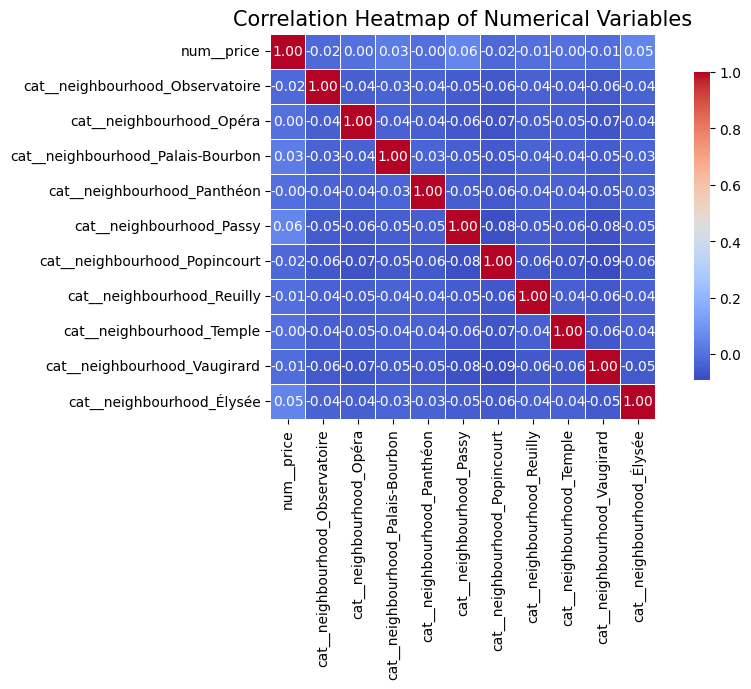

In [26]:
numerical_columns_three = [
    'num__price',
    'cat__neighbourhood_Observatoire', 
    'cat__neighbourhood_Opéra', 
    'cat__neighbourhood_Palais-Bourbon', 
    'cat__neighbourhood_Panthéon', 
    'cat__neighbourhood_Passy', 
    'cat__neighbourhood_Popincourt', 
    'cat__neighbourhood_Reuilly', 
    'cat__neighbourhood_Temple', 
    'cat__neighbourhood_Vaugirard', 
    'cat__neighbourhood_Élysée'

]

scaled_numerical_three_df = processed_df[numerical_columns_three]

# Calculate the correlation matrix
correlation_matrix = scaled_numerical_three_df.corr()

# Set figure
plt.figure(figsize=(10, 5))

# heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
    linewidths=0.5, square=True, cbar_kws={"shrink": .8})

# title
plt.title('Correlation Heatmap of Numerical Variables', fontsize=15)

# plot
plt.show()

In [27]:
del processed_df

These actions do not seem to help with the preprocessing of the data

How prices behave in different areas of the city: 

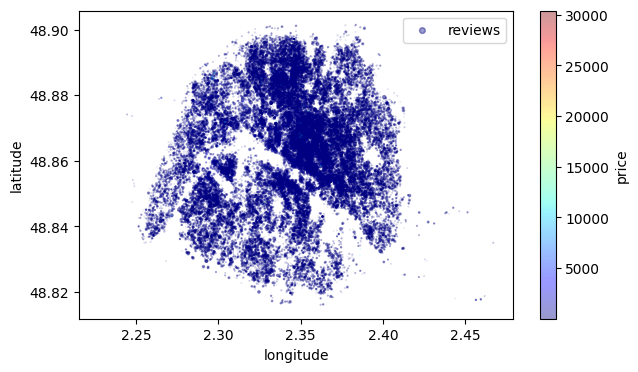

In [28]:
listings.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=listings["number_of_reviews"]/100, label="reviews", figsize=(7,4),
c="price", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

Basic Price Statistics:
count    60093.000000
mean       252.590485
std        594.242875
min          7.000000
25%        100.000000
50%        150.000000
75%        250.000000
max      30400.000000
Name: price, dtype: float64


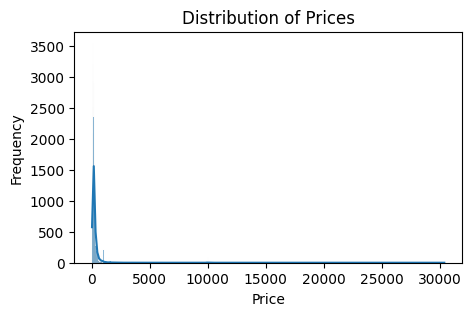


Average Price by Neighborhood (Top 10):
neighbourhood
Élysée                 400.919013
Passy                  371.884517
Palais-Bourbon         350.681380
Luxembourg             327.394589
Louvre                 323.144845
Hôtel-de-Ville         314.685039
Bourse                 271.497105
Batignolles-Monceau    268.526671
Opéra                  254.229444
Temple                 251.371289
Name: price, dtype: float64


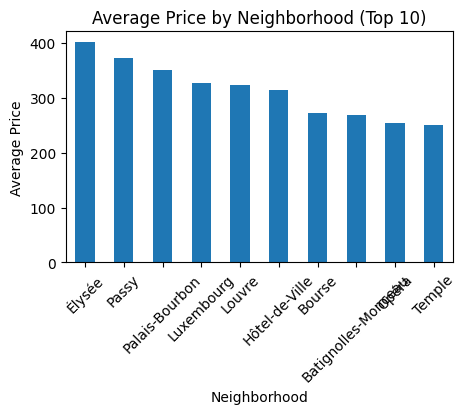


Average Price by Room Type:
room_type
Hotel room         306.933213
Entire home/apt    259.783621
Private room       179.769480
Shared room         94.336207
Name: price, dtype: float64


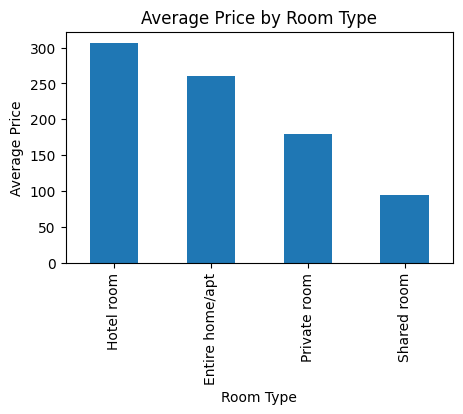

In [29]:
# 1. Basic price statistics
print("Basic Price Statistics:")
print(listings['price'].describe())

# 2. Price distribution
plt.figure(figsize=(5, 3))
sns.histplot(listings['price'], kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 3. Price by neighborhood
avg_price_by_neighborhood = listings.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)
print("\nAverage Price by Neighborhood (Top 10):")
print(avg_price_by_neighborhood.head(10))

plt.figure(figsize=(5, 3))
avg_price_by_neighborhood.head(10).plot(kind='bar')
plt.title('Average Price by Neighborhood (Top 10)')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

# 4. Price by room type
avg_price_by_room_type = listings.groupby('room_type')['price'].mean().sort_values(ascending=False)
print("\nAverage Price by Room Type:")
print(avg_price_by_room_type)

plt.figure(figsize=(5, 3))
avg_price_by_room_type.plot(kind='bar')
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.show()

These graphs show a relation with room type and neighbourhood.

Checking correlation and covariance with built-in methods

In [30]:
# Identify all numerical columns (excluding 'price')
numeric_cols = listings.select_dtypes(include=np.number).columns
numeric_cols = numeric_cols.drop('price')

# Calculate correlations with 'price'
correlations = listings[numeric_cols].corrwith(listings['price'])

# Sort correlations in descending order
correlations = correlations.sort_values(ascending=False)

# Print the results
print(correlations)

availability_365                  0.089573
id                                0.048571
host_id                           0.030488
calculated_host_listings_count    0.000066
latitude                         -0.006404
minimum_nights                   -0.027589
reviews_per_month                -0.039151
number_of_reviews                -0.052971
longitude                        -0.071835
number_of_reviews_ltm            -0.075266
dtype: float64


array([[<AxesSubplot: xlabel='price', ylabel='price'>,
        <AxesSubplot: xlabel='number_of_reviews', ylabel='price'>,
        <AxesSubplot: xlabel='reviews_per_month', ylabel='price'>,
        <AxesSubplot: xlabel='number_of_reviews_ltm', ylabel='price'>],
       [<AxesSubplot: xlabel='price', ylabel='number_of_reviews'>,
        <AxesSubplot: xlabel='number_of_reviews', ylabel='number_of_reviews'>,
        <AxesSubplot: xlabel='reviews_per_month', ylabel='number_of_reviews'>,
        <AxesSubplot: xlabel='number_of_reviews_ltm', ylabel='number_of_reviews'>],
       [<AxesSubplot: xlabel='price', ylabel='reviews_per_month'>,
        <AxesSubplot: xlabel='number_of_reviews', ylabel='reviews_per_month'>,
        <AxesSubplot: xlabel='reviews_per_month', ylabel='reviews_per_month'>,
        <AxesSubplot: xlabel='number_of_reviews_ltm', ylabel='reviews_per_month'>],
       [<AxesSubplot: xlabel='price', ylabel='number_of_reviews_ltm'>,
        <AxesSubplot: xlabel='number_of_reviews', 

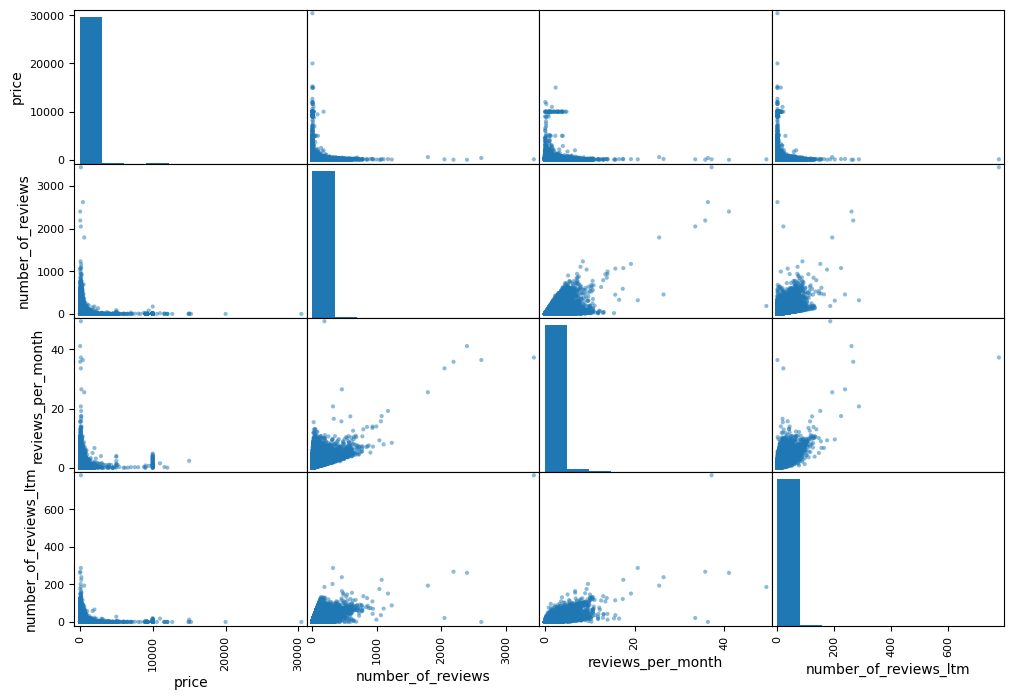

In [31]:
from pandas.plotting import scatter_matrix
attributes = ['price', 'number_of_reviews','reviews_per_month', 'number_of_reviews_ltm']
scatter_matrix(listings[attributes], figsize=(12, 8))


The matrix indicates the existence of a relationship between the price and the number of reviews, with higher-prices listings generally receiving fewer reviews.  Furthermore, the total number of reviews, monthly reviews, and yearly reviews are highly correlated, as expected.

array([[<AxesSubplot: xlabel='price', ylabel='price'>,
        <AxesSubplot: xlabel='minimum_nights', ylabel='price'>,
        <AxesSubplot: xlabel='calculated_host_listings_count', ylabel='price'>,
        <AxesSubplot: xlabel='availability_365', ylabel='price'>],
       [<AxesSubplot: xlabel='price', ylabel='minimum_nights'>,
        <AxesSubplot: xlabel='minimum_nights', ylabel='minimum_nights'>,
        <AxesSubplot: xlabel='calculated_host_listings_count', ylabel='minimum_nights'>,
        <AxesSubplot: xlabel='availability_365', ylabel='minimum_nights'>],
       [<AxesSubplot: xlabel='price', ylabel='calculated_host_listings_count'>,
        <AxesSubplot: xlabel='minimum_nights', ylabel='calculated_host_listings_count'>,
        <AxesSubplot: xlabel='calculated_host_listings_count', ylabel='calculated_host_listings_count'>,
        <AxesSubplot: xlabel='availability_365', ylabel='calculated_host_listings_count'>],
       [<AxesSubplot: xlabel='price', ylabel='availability_365'>,


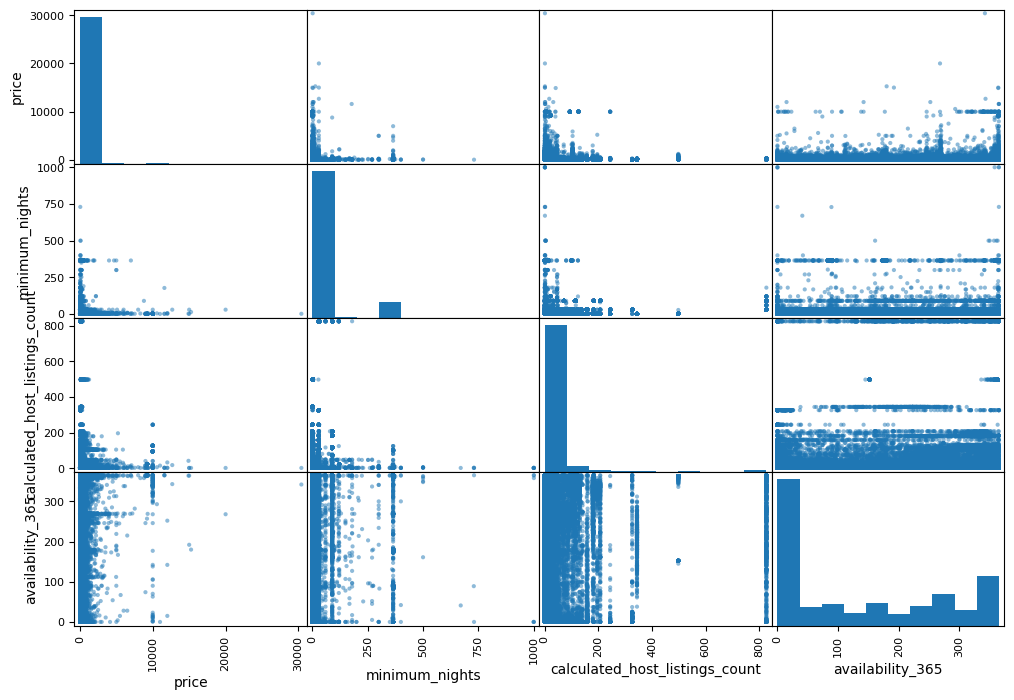

In [32]:
attributes = ['price','minimum_nights', 'calculated_host_listings_count', 'availability_365']
scatter_matrix(listings[attributes], figsize=(12, 8))

array([[<AxesSubplot: xlabel='price', ylabel='price'>,
        <AxesSubplot: xlabel='number_of_reviews', ylabel='price'>],
       [<AxesSubplot: xlabel='price', ylabel='number_of_reviews'>,
        <AxesSubplot: xlabel='number_of_reviews', ylabel='number_of_reviews'>]],
      dtype=object)

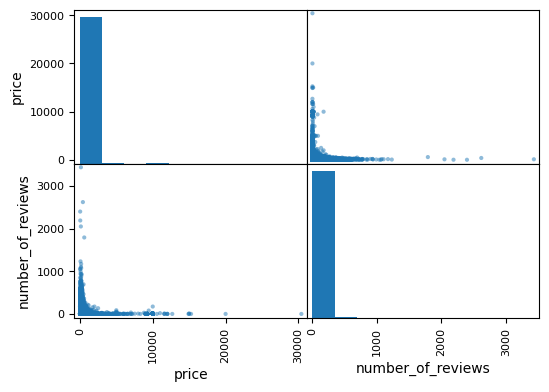

In [33]:
attributes = ['price', 'number_of_reviews']
scatter_matrix(listings[attributes], figsize=(6, 4))


array([[<AxesSubplot: xlabel='price', ylabel='price'>,
        <AxesSubplot: xlabel='calculated_host_listings_count', ylabel='price'>],
       [<AxesSubplot: xlabel='price', ylabel='calculated_host_listings_count'>,
        <AxesSubplot: xlabel='calculated_host_listings_count', ylabel='calculated_host_listings_count'>]],
      dtype=object)

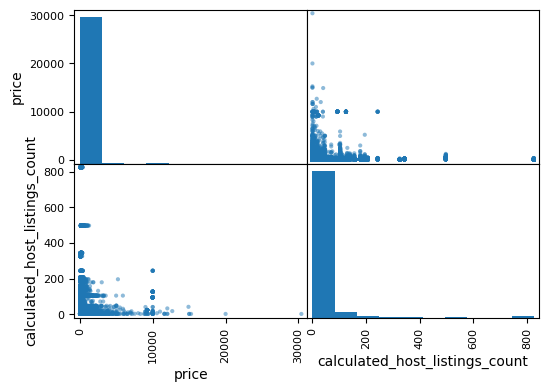

In [34]:
attributes = ['price', 'calculated_host_listings_count']
scatter_matrix(listings[attributes], figsize=(6, 4))

The most notable relationship is a weak negative correlation between price and the number of listings a host has, and a weak positive correlation with the number of reviews.  Many other relationships are unclear and require further analysis.

Now that we have seen how correlation works in the data set, let's check these values with correlation, but this time calculates by formula.

In [35]:
# Selecting numeric columns for correlation as a first step
numeric_columns = listings[['price', 'minimum_nights', 'number_of_reviews', 
                                    'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']]

# Calculating covariance and correlation manually (example for 'price' and other columns)
def calculate_cov_corr(df, col1, col2):
    mean1, mean2 = df[col1].mean(), df[col2].mean()
    covariance = ((df[col1] - mean1) * (df[col2] - mean2)).sum() / (len(df) )
    col1_std = ((df[col1] - mean1)**2).sum() / (len(df) - 1)**0.5
    col2_std = ((df[col2] - mean2)**2).sum() / (len(df) - 1)**0.5
    correlation = covariance / (col1_std * col2_std)
    return covariance, correlation

# Calculating and storing the covariance and correlation.
results = {}
base_col = 'price'
for col in numeric_columns.columns:
    if col != base_col:
        cov, corr = calculate_cov_corr(numeric_columns, base_col, col)
        results[col] = {'Covariance': cov, 'Correlation': corr}

results

{'minimum_nights': {'Covariance': -433.4582447974063,
  'Correlation': -1.7651987497797568e-12},
 'number_of_reviews': {'Covariance': -1354.2505313778947,
  'Correlation': -2.0648935852623784e-11},
 'reviews_per_month': {'Covariance': -18.72428287676491,
  'Correlation': -6.52910398694815e-10},
 'calculated_host_listings_count': {'Covariance': 2.8835729447164358,
  'Correlation': 1.5168531860148605e-14},
 'availability_365': {'Covariance': 4285.362078693001,
  'Correlation': 1.0978603418586925e-11},
 'number_of_reviews_ltm': {'Covariance': -398.0596939931887,
  'Correlation': -1.3598702310090495e-10}}

The covariance and correlation values between 'price' and other numerical features have been computed manually. Several features, such as  'minimum_nights', and 'number_of_reviews', exhibit correlations close to zero, indicating minimal linear relationships with 'price'.

The dataset includes a variety of features, such as 'price', 'room_type', and 'reviews_per_month'. However, 'price' column has missing values and is central to our analysis.  I tried using KNN, but it didn't work right.

So, finally price impute is going to be made based on a stronger relation between price, room type and neighborhood, by using the median for those variables. And the use of the median is because for skewed data it is less susceptible to outliers and extreme values.

Then also we are Dropping license, replacing reviews per month with a 0 and looking for lat_review data in reviews.

In [36]:
listings['reviews_per_month'].fillna(0, inplace=True)

In [37]:
listings = listings.drop([ 'license'], axis=1)

Replace Nan in price for the median, taking neighborhood and room type.

In [38]:
# Group data by neighbourhood and room_type and compute median price for each group
median_prices = listings.groupby(['neighbourhood', 'room_type'])['price'].median().reset_index()

#Rename the column to avoid future issues
median_prices = median_prices.rename(columns={'price': 'median_price'})

# Merge median prices back into the main DataFrame
listings = pd.merge(listings, median_prices, on=['neighbourhood', 'room_type'], how='left')


#Impute missing prices using the median price for each group
listings['price'] = np.where(listings['price'].isna(), listings['median_price'], listings['price'])


# Drop the temporary 'median_price' column
listings = listings.drop(columns=['median_price'])

# Print the DataFrame to verify imputation
print(listings.head())

      id                                          name  host_id  host_name  \
0   5396  Your perfect Paris studio on Île Saint-Louis     7903     Borzou   
1   7964                  Sunny apartment with balcony    22155      Anaïs   
2   9952                     Paris petit coin douillet    33534  Elisabeth   
3  11487          Heart of  Paris, brand new aparment.    42666   Brigitte   
4  12452                                Voltaire Charm    48733      Irene   

    neighbourhood  latitude  longitude        room_type  price  \
0  Hôtel-de-Ville  48.85247    2.35835  Entire home/apt   88.0   
1           Opéra  48.87417    2.34245  Entire home/apt  169.0   
2      Popincourt  48.86238    2.36957  Entire home/apt  150.0   
3      Popincourt  48.86351    2.37110  Entire home/apt   80.0   
4      Popincourt  48.85974    2.37932  Entire home/apt  201.0   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0               3                425  2024-11-23               

Let's try to replace last_review with the dates on reviews

In [39]:
# Get the most recent review date for each listing
latest_reviews = reviews.loc[reviews.groupby('listing_id')['date'].idxmax()].reset_index(drop=True)

# Display the latest_reviews DataFrame
print("Latest Reviews DataFrame:")
print(latest_reviews)

# Filter for entries with NaN in the 'last_review' column
nan_reviews = listings[listings['last_review'].isna()]

# Merge only for the listings with NaN in last_review
merged_df = pd.merge(nan_reviews, latest_reviews, left_on='id', right_on='listing_id', how='right')

# Display the merged DataFrame before updating
print("\nMerged DataFrame:")
print(merged_df)

# Update last_review for only those listings with NaN 
listings.loc[listings['last_review'].isna(), 'last_review'] = merged_df['date']

# Display the updated  DataFrame
print("\nUpdated DataFrame:")
print(listings)

Latest Reviews DataFrame:
                listing_id       date
0                     3109 2019-10-24
1                     5396 2024-11-23
2                     7397 2024-11-24
3                     7964 2015-09-14
4                     9952 2024-09-24
...                    ...        ...
67171  1301237374868511796 2024-12-06
67172  1301828427514482147 2024-12-05
67173  1302810669159442322 2024-12-05
67174  1302813821561049702 2024-12-05
67175  1302863711370888748 2024-12-08

[67176 rows x 2 columns]

Merged DataFrame:
       id name  host_id host_name neighbourhood  latitude  longitude  \
0     NaN  NaN      NaN       NaN           NaN       NaN        NaN   
1     NaN  NaN      NaN       NaN           NaN       NaN        NaN   
2     NaN  NaN      NaN       NaN           NaN       NaN        NaN   
3     NaN  NaN      NaN       NaN           NaN       NaN        NaN   
4     NaN  NaN      NaN       NaN           NaN       NaN        NaN   
...    ..  ...      ...       ...        

In [40]:
# Missing Values ("N/A"s)
missing_values = listings.isnull().sum().sort_values(ascending=False)/len(listings)*100
missing_values

last_review                       11.547715
host_name                          0.009887
name                               0.000000
id                                 0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
host_id                            0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
reviews_per_month                  0.000000
calculated_host_listings_count     0.000000
availability_365                   0.000000
number_of_reviews_ltm              0.000000
dtype: float64

In [41]:
listings.to_csv("listings_cleaned.csv", index=False)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91031 entries, 0 to 91030
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              91031 non-null  int64         
 1   name                            91031 non-null  object        
 2   host_id                         91031 non-null  int64         
 3   host_name                       91022 non-null  object        
 4   neighbourhood                   91031 non-null  object        
 5   latitude                        91031 non-null  float64       
 6   longitude                       91031 non-null  float64       
 7   room_type                       91031 non-null  object        
 8   price                           91031 non-null  float64       
 9   minimum_nights                  91031 non-null  int64         
 10  number_of_reviews               91031 non-null  int64         
 11  la

# Question 2: Clustering Analysis

For the clustering analysis, I will be using the listings dataset to answer the question of the reasoning behind the factors of increasing
Airbnb rental prices. I am using the listings dataset because the reviews dataset does not present sufficient price data to serve as a useful indication of increasing rental prices. 

In [42]:
#I load the appropriate dataset
df_ca = pd.read_csv('listings.csv')

#From the previous step, I select the relevant features for the analysis and drop those that we found to be irrelvant or empty 
df_ca.drop(columns=['neighbourhood_group', 'id', 'host_id', 'name', 'host_name', 'license'], inplace=True)

#Since we found in the EDA that last_review should be a datetime object, I convert it
df_ca['last_review'] = pd.to_datetime(df_ca['last_review'])

#As done in the EDA, I use an imputation strategy to handle the missing values in price and fill all of the NaN values in reviews_per_month with 0
df_ca['reviews_per_month'].fillna(0, inplace=True)
df_ca['price'] = df_ca.groupby(['neighbourhood','room_type'])['price'].transform(lambda x:x.fillna(x.median()))

After running the process before, the last_review variable kept giving me problems so I decided to drop it completely because it has so many empty values. 

In [43]:
df_ca.drop(columns=['last_review'], inplace=True)

Due to the distribution of prices, I think it would be a good idea to introduce a way of dealing with outliers - by capping those extreme values. Because in clustering, this can lead to misuse of the algorithms, and give weird results. 

In [44]:
#I select the relevant features to be used for our clustering analysis
features = ['neighbourhood','price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm','room_type', 'latitude', 'longitude']

#To make sure everything is running smoothly I want to make sure that there are no more empty variables 
missing_values = df_ca.isnull().sum()
print("Missing values after imputation:\n", missing_values)

Missing values after imputation:
 neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64


As we saw in class, a scatter matrix is useful to see relationships between variables

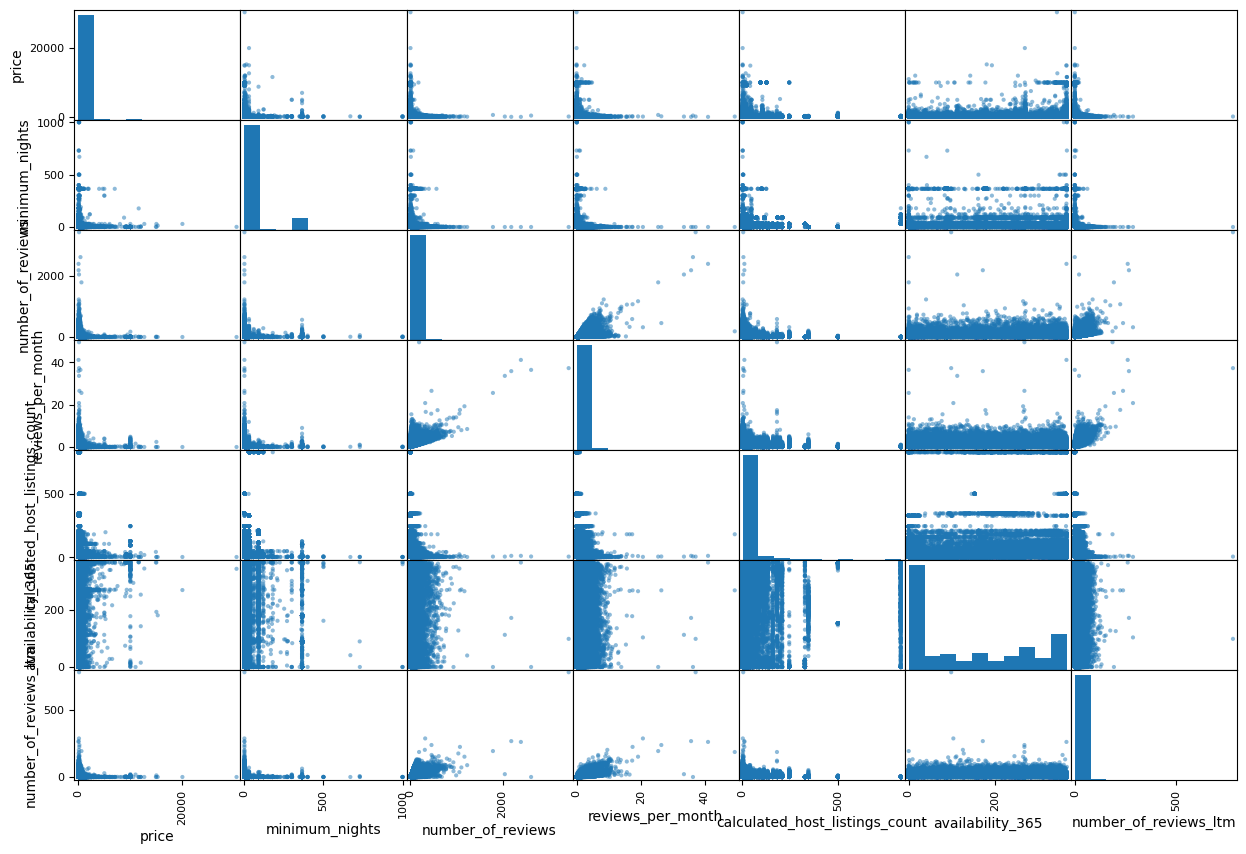

In [45]:
#implementing the scatter matrix but excludes lattitude and longitude
from pandas.plotting import scatter_matrix

# Selecting only numerical columns
num_features = ['price', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'calculated_host_listings_count', 
                'availability_365', 'number_of_reviews_ltm']

scatter_matrix(df_ca[num_features], figsize=(15, 10))
plt.show()

We move onto our preprocessing step - which will includea RobustScaler() for numerical variables because it handles outliers betters. And then it will include a simple OneHotEncoder() for the categorical features since their relation to the price is still significant!

It is more simple to run the preprocessing step by using the ColumnTransformer()#

In [46]:
#First I seperate the variables into categorical and numerical variables
categorical_features = ['room_type', 'neighbourhood']
numerical_features = ['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']

preprocessor = ColumnTransformer(
    transformers = [('num', RobustScaler(), numerical_features), ('cat', OneHotEncoder(), categorical_features)], remainder = 'passthrough')

#Then I transform all of the data
processed_data = preprocessor.fit_transform(df_ca)
processed_df = pd.DataFrame(processed_data, columns = preprocessor.get_feature_names_out())
processed_df[['latitude', 'longitude']] = df_ca[['latitude', 'longitude']].reset_index(drop=True)

In [47]:
processed_df

,num__price,num__minimum_nights,num__number_of_reviews,num__calculated_host_listings_count,num__availability_365,num__number_of_reviews_ltm,cat__room_type_Entire home/apt,cat__room_type_Hotel room,cat__room_type_Private room,cat__room_type_Shared room,...,cat__neighbourhood_Popincourt,cat__neighbourhood_Reuilly,cat__neighbourhood_Temple,cat__neighbourhood_Vaugirard,cat__neighbourhood_Élysée,remainder__latitude,remainder__longitude,remainder__reviews_per_month,latitude,longitude
0,-0.662921,0.000000,19.090909,0.0,-0.041199,7.142857,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,48.852470,2.358350,2.26,48.852470,2.358350
1,0.247191,1.333333,0.000000,0.0,-0.329588,-0.142857,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,48.874170,2.342450,0.03,48.874170,2.342450
2,0.033708,0.333333,2.136364,0.0,0.606742,0.285714,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,48.862380,2.369570,0.36,48.862380,2.369570
3,-0.752809,9.000000,0.363636,1.0,0.591760,0.571429,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,48.863510,2.371100,0.09,48.863510,2.371100
4,0.606742,-0.666667,2.590909,0.0,-0.202247,0.428571,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,48.859740,2.379320,0.77,48.859740,2.379320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91026,-0.528090,9.000000,-0.227273,0.0,-0.011236,-0.142857,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,48.888360,2.382689,0.00,48.888360,2.382689
91027,-0.752809,-0.666667,-0.227273,0.0,0.344569,-0.142857,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,48.864770,2.391108,0.00,48.864770,2.391108
91028,7.539326,-0.666667,-0.227273,106.0,0.659176,-0.142857,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,48.859996,2.369208,0.00,48.859996,2.369208
91029,7.786517,-0.666667,-0.227273,106.0,0.853933,-0.142857,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,48.852970,2.288317,0.00,48.852970,2.288317


We learned in class to define helper functions to help us so I will do the same here

Next, I will find the optimal number of k values for K-Means Clustering using the elbow method that we learned in class. 

In [48]:
#Like in class, I will be creating a helper function for the elbow method because then we can test different variables
def plot_elbow(X, k_min=2, k_max=10):
    """
    Plots the Elbow Method to visualize inertia values for different K values.
    
    Arguments:
    X -- Processed dataset (scaled & encoded)
    k_min -- Minimum number of clusters to try
    k_max -- Maximum number of clusters to try
    """
    inertias = []
    ks = range(k_min, k_max + 1)
    
    for k in ks:
        km = KMeans(n_clusters=k, random_state=1, n_init=10)
        km.fit(X)
        inertias.append(km.inertia_)

    # Here we plot the elbow
    plt.figure(figsize=(4, 4))
    plt.plot(ks, inertias, marker='o')
    plt.title("Elbow Method (Inertia)")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (SSE)")
    plt.show()

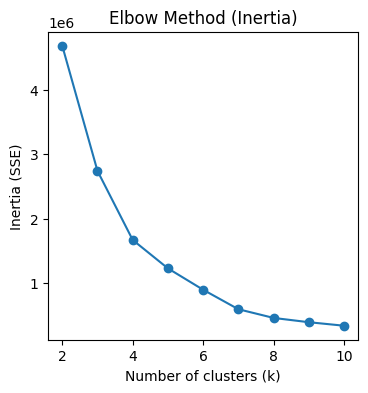

In [49]:
plot_elbow(processed_df[['num__price', 'num__minimum_nights']], k_min=2, k_max=10)

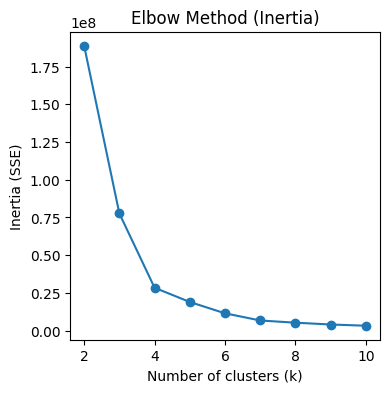

In [50]:
plot_elbow(processed_df[['num__price', 'num__calculated_host_listings_count']], k_min=2, k_max=10)

I want to see how each of the variables interacts with the price so I will call the functions necessary

In [51]:
#The KMeans helper function is also going to be useful to test different variables. 
def KmeansAndPlot(col1_name, col2_name, n_clusters):
    """
    Performs K-Means clustering and plots the resulting clusters on preprocessed data.
    Uses a manually specified number of clusters.
    
    Arguments:
    col1_name, col2_name -- Column names (from processed_df) to cluster and plot
    n_clusters -- The number of clusters to use for K-Means
    """
    # Extract the features from our preprocessing dataset that was created before
    X = processed_df[[col1_name, col2_name]]

    km = KMeans(n_clusters=n_clusters, random_state=1)
    km.fit(X)
    labels = km.labels_

    plt.figure(figsize=(4, 3))

    # Visualizing our results in the scatter plot
    plt.scatter(X[col1_name], X[col2_name], c=labels, cmap='Set1', alpha=0.6, edgecolors='k')
    plt.title(f"K-Means Clustering ({n_clusters} Clusters)")
    plt.xlabel(col1_name)
    plt.ylabel(col2_name)
    plt.show()

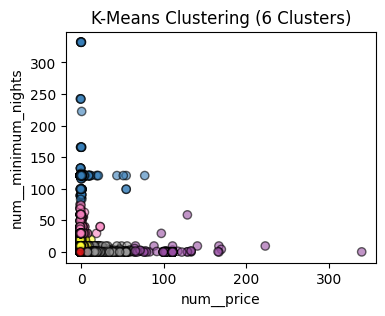

In [52]:
chosen_k = 6  
KmeansAndPlot('num__price', 'num__minimum_nights', chosen_k)

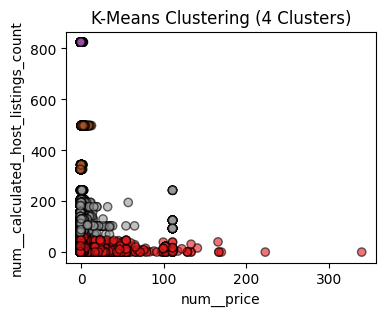

In [53]:
chosen_k = 4  
KmeansAndPlot('num__price', 'num__calculated_host_listings_count', chosen_k)

Now I am going to try DBSCAN with the geographical data to see if we can uncover anything

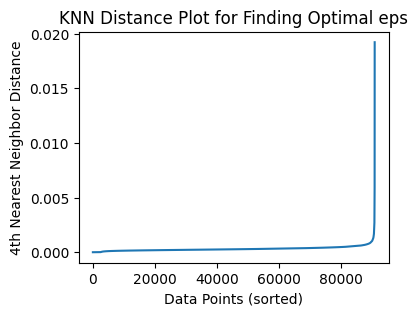

In [54]:
#KNN is used to reveal the optimal eps value
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Extract latitude & longitude since we want to find the optimal eps based on these variables
geo_data = processed_df[['latitude', 'longitude']]

# Use NearestNeighbors to find the best epsilon
neighbors = NearestNeighbors(n_neighbors=5)  
neighbors_fit = neighbors.fit(geo_data)
distances, indices = neighbors_fit.kneighbors(geo_data)

distances = np.sort(distances[:, 4])  
plt.figure(figsize=(4, 3))
plt.plot(distances)
plt.title("KNN Distance Plot for Finding Optimal eps")
plt.xlabel("Data Points (sorted)")
plt.ylabel("4th Nearest Neighbor Distance")
plt.show()

In [55]:
from sklearn.cluster import DBSCAN

#testing different eps values
for test_eps in [0.001, 0.002, 0.003, 0.004, 0.005]:
    dbscan = DBSCAN(eps=test_eps, min_samples=10)
    geo_clusters = dbscan.fit_predict(geo_data)

    num_clusters = len(set(geo_clusters)) - (1 if -1 in geo_clusters else 0)  # we exclude noise
    print(f"eps = {test_eps} ==> Found {num_clusters} clusters")


eps = 0.001 ==> Found 18 clusters
eps = 0.002 ==> Found 5 clusters
eps = 0.003 ==> Found 1 clusters
eps = 0.004 ==> Found 1 clusters
eps = 0.005 ==> Found 1 clusters


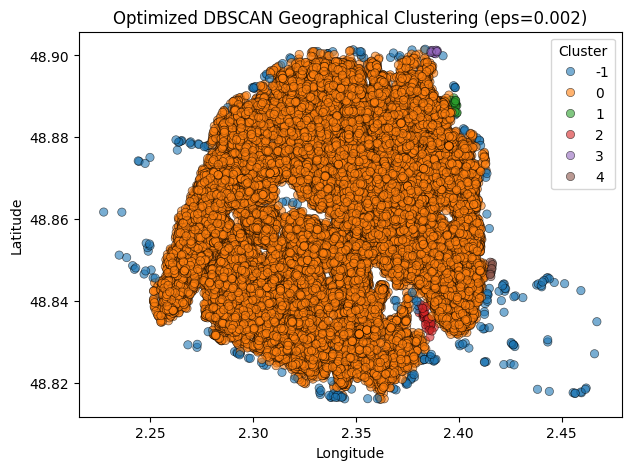

In [56]:
# Apply DBSCAN with the eps found in the previous step
dbscan = DBSCAN(eps=0.002, min_samples=10)  
geo_clusters = dbscan.fit_predict(geo_data)

# assigning clusters back into processed_df
processed_df['Geo_Cluster'] = geo_clusters  

# visualization
plt.figure(figsize=(7, 5))
sns.scatterplot(x=processed_df['longitude'], y=processed_df['latitude'], hue=processed_df['Geo_Cluster'],
                palette='tab10', alpha=0.6, edgecolor='k')
plt.title(f"Optimized DBSCAN Geographical Clustering (eps=0.002)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.show()

In [57]:
#checking the range of longtiude and latitude variables since the reuslts of DBSCAN were really weird
print("Latitude Range:")
print(f"Min: {processed_df['latitude'].min()}, Max: {processed_df['latitude'].max()}")
print(f"Range: {processed_df['latitude'].max() - processed_df['latitude'].min()}")

print("\nLongitude Range:")
print(f"Min: {processed_df['longitude'].min()}, Max: {processed_df['longitude'].max()}")
print(f"Range: {processed_df['longitude'].max() - processed_df['longitude'].min()}")


Latitude Range:
Min: 48.816090055186486, Max: 48.90150973482009
Range: 0.08541967963360264

Longitude Range:
Min: 2.22742, Max: 2.46712
Range: 0.23970000000000002


Since the range between longtiude values and latitude values is so small, DBSCAN does not work!

# Question 3: PCA

Preprocessing

In [58]:
# Coordinates of major landmarks in Paris (latitude, longitude)
landmarks = {
    'Eiffel Tower': (48.8584, 2.2945),
    'Center': (48.857552, 2.351232),
}

# Function to calculate distance to each landmark
def calculate_distances(row):
    distances = {}
    for landmark, (lat, lon) in landmarks.items():
        listing_coords = (row['latitude'], row['longitude'])
        landmark_coords = (lat, lon)
        # Calculate distance
        distance = haversine(listing_coords, landmark_coords, unit=Unit.KILOMETERS)
        distances[f'distance_to_{landmark.replace(" ", "_")}'] = distance
    return pd.Series(distances)

In [59]:
df = pd.read_csv('listings.csv')
df = df.loc[:, ~df.columns.str.startswith('neighbourhood_') & ~df.columns.str.startswith('room_type')]
columns_to_drop = [ 
            'id',
            'name',
            'host_id', 
            'host_name', 
            'neighbourhood', 
            'license',
            'last_review']

df = df.drop(columns=columns_to_drop)
df.dropna(inplace=True)
df['reviews_per_month'].fillna(0, inplace=True)
df = df.join(df.apply(calculate_distances, axis=1))

# Scale the data
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])
df.info()
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 44965 entries, 0 to 90956
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        44965 non-null  float64
 1   longitude                       44965 non-null  float64
 2   price                           44965 non-null  float64
 3   minimum_nights                  44965 non-null  float64
 4   number_of_reviews               44965 non-null  float64
 5   reviews_per_month               44965 non-null  float64
 6   calculated_host_listings_count  44965 non-null  float64
 7   availability_365                44965 non-null  float64
 8   number_of_reviews_ltm           44965 non-null  float64
 9   distance_to_Eiffel_Tower        44965 non-null  float64
 10  distance_to_Center              44965 non-null  float64
dtypes: float64(11)
memory usage: 5.1 MB
latitude                          0
longitude                 

Applying PCA / Longitude and Latitude

We just used all continuous variables (with the exception of IDs) 

In [60]:
target = 'price'  #  we're predicting 'price'

# Independent variables (X) and target variable (y)
X = df[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']]  # Excluding the target from features

# Apply PCA
pca = PCA(n_components=4)  # Specify the number of components you want (e.g., 2)
pca.fit(X)  # Fit the model to your data

# Create a DataFrame with contributions for all PCs
all_pc_contributions = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
    index=X.columns
)

print("Feature contributions to each Principal Component:")
print(all_pc_contributions)

# Print explained variance ratio for each PC
print("\nExplained variance ratio for each PC:")
print(pd.Series(pca.explained_variance_ratio_, index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]))

Feature contributions to each Principal Component:
                                     PC1       PC2       PC3       PC4
latitude                       -0.011498 -0.263095  0.675145 -0.487040
longitude                       0.016628 -0.462133  0.494105  0.238667
minimum_nights                 -0.135962  0.410891  0.390512  0.533775
number_of_reviews               0.521065  0.093087  0.096043  0.077633
reviews_per_month               0.579380  0.049461 -0.002715 -0.040418
calculated_host_listings_count -0.091655  0.462677  0.061052 -0.635782
availability_365               -0.012716  0.565885  0.366077  0.093257
number_of_reviews_ltm           0.604445  0.054540  0.023858 -0.018392

Explained variance ratio for each PC:
PC1    0.289575
PC2    0.156060
PC3    0.130943
PC4    0.120547
dtype: float64


Applying PCA / Distance to Landmarks

In [61]:
# Independent variables (X) and target variable (y)
X = df[['distance_to_Eiffel_Tower', 'distance_to_Center', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']]  # Excluding the target from features

# Apply PCA
pca = PCA(n_components=4)  # Specify the number of components you want (e.g., 2)
pca.fit(X)  # Fit the model to your data

# Create a DataFrame with contributions for all PCs
all_pc_contributions = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
    index=X.columns
)

print("Feature contributions to each Principal Component:")
print(all_pc_contributions)

# Print explained variance ratio for each PC
print("\nExplained variance ratio for each PC:")
print(pd.Series(pca.explained_variance_ratio_, index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]))

Feature contributions to each Principal Component:
                                     PC1       PC2       PC3       PC4
distance_to_Eiffel_Tower       -0.005698 -0.608990  0.377527  0.136114
distance_to_Center             -0.096846  0.338498 -0.652778  0.264122
minimum_nights                 -0.133411  0.313770  0.411564  0.576306
number_of_reviews               0.520607  0.073879  0.092025  0.085981
reviews_per_month               0.576020  0.063719 -0.037784 -0.008185
calculated_host_listings_count -0.086017  0.414775  0.296166 -0.723187
availability_365               -0.010956  0.480392  0.405393  0.221571
number_of_reviews_ltm           0.602031  0.061372 -0.003966  0.005672

Explained variance ratio for each PC:
PC1    0.291106
PC2    0.159869
PC3    0.143066
PC4    0.120578
dtype: float64


PCA Analysis

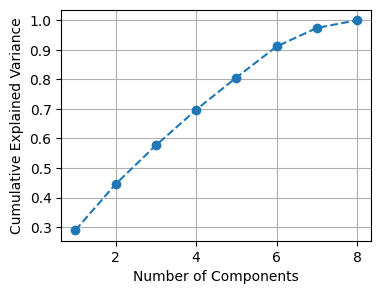

In [62]:
# Independent variables (X) and target variable (y)
X = df[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']]  # Excluding the target from features

# Apply PCA
pca = PCA(n_components=8) 
pca.fit(X)  # Fit the model to your data

# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a plot
plt.figure(figsize=(4, 3))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
#plt.title('Scree plot (Lon/Lat)')
plt.grid(True)
plt.savefig('/work/PCA1.png', dpi=300)
plt.savefig("PCA1.pdf", format="pdf", bbox_inches="tight")
plt.show()

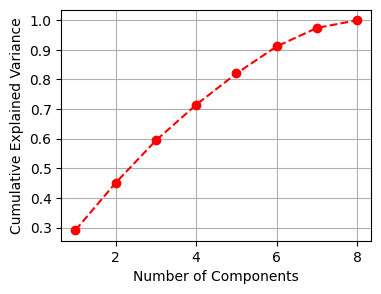

In [63]:
# Independent variables (X) and target variable (y)
X = df[['distance_to_Eiffel_Tower', 'distance_to_Center', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']]  # Excluding the target from features


# Apply PCA
pca = PCA(n_components=8) 
pca.fit(X)  # Fit the model to your data

# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a plot
plt.figure(figsize=(4, 3))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--', color='r')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
#plt.title('Scree plot (distances)')
plt.grid(True)
plt.savefig('/work/PCA2.png', dpi=300)
plt.savefig("/work/PCA2.pdf", format="pdf", bbox_inches="tight")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=931c32c8-aa82-44c1-8af9-28f8ced648ec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>